# 1. Import Libraries

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Time series analysis
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


# 2. Load the Dataset

In [4]:
# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

# Display the first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 3. Data Preparation

Data Preparation & Quality

>Ensured reliable analysis by removing incomplete customer data and isolating returns.

>Clean, formatted data enabled accurate time-based and monetary calculations.

**3.1. Initial Data Inspection**

In [5]:
# Check data types and missing values
df.info()

# Summary statistics
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN


**3.2. Handle Missing Values**

In [6]:
# Check missing values
df.isnull().sum()

# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Verify missing values are handled
df.isnull().sum()


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


**3.3. Handle Negative Quantities**

In [7]:
# Separate returns data
returns = df[df['Quantity'] < 0]

# Keep only positive quantity transactions
df = df[df['Quantity'] > 0]


**3.4. Convert Data Types**

In [8]:
# Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert CustomerID to string
df['CustomerID'] = df['CustomerID'].astype(str)


**3.5. Create Total Revenue Column**

In [9]:
# Calculate total revenue per transaction
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']


# 4. Exploratory Data Analysis (EDA)

Exploratory Insights

>Monthly Sales Trend: Identified peak sales periods, guiding seasonal marketing and inventory planning.

>Top-Selling Products: Pinpointed key SKUs to prioritize for promotions and stock management.

>Customer Purchase Frequency: Revealed a need for better retention strategies to convert one-time buyers into repeat customers.

**4.1. Sales Over Time**

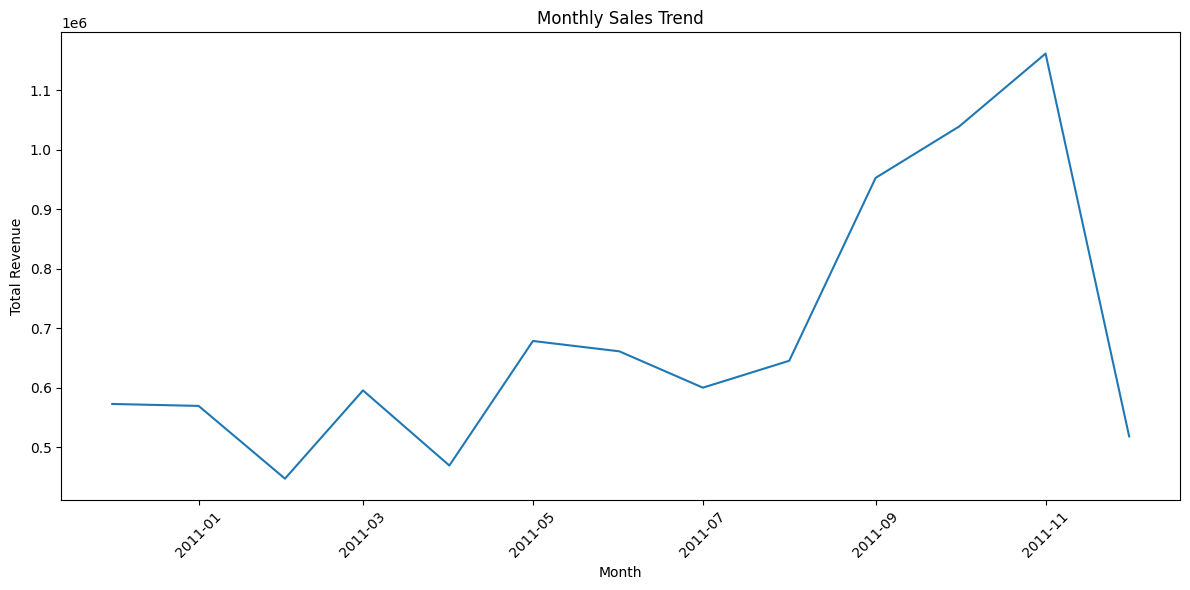

In [10]:
# Extract month and year
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# Group by Month
monthly_sales = df.groupby('Month')['TotalRevenue'].sum().reset_index()

# Convert Month back to datetime for plotting
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Plot Monthly Sales Trend
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='TotalRevenue')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**4.2. Top Selling Products**

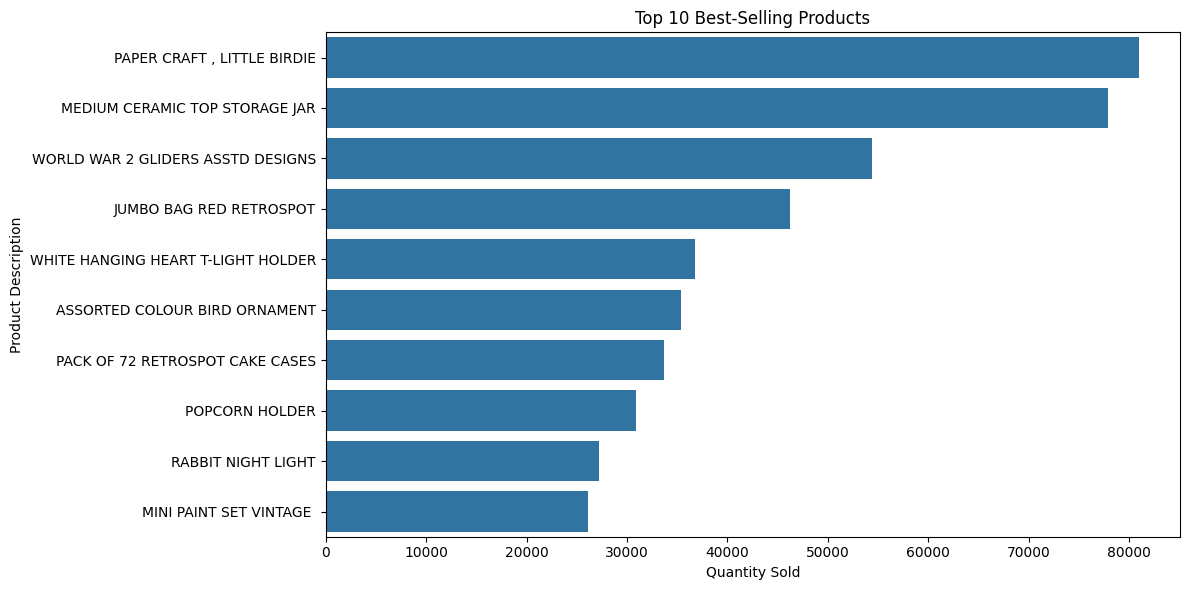

In [11]:
# Top products by quantity sold
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot Top 10 Best-Selling Products
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


**4.3. Customer Purchase Frequency**

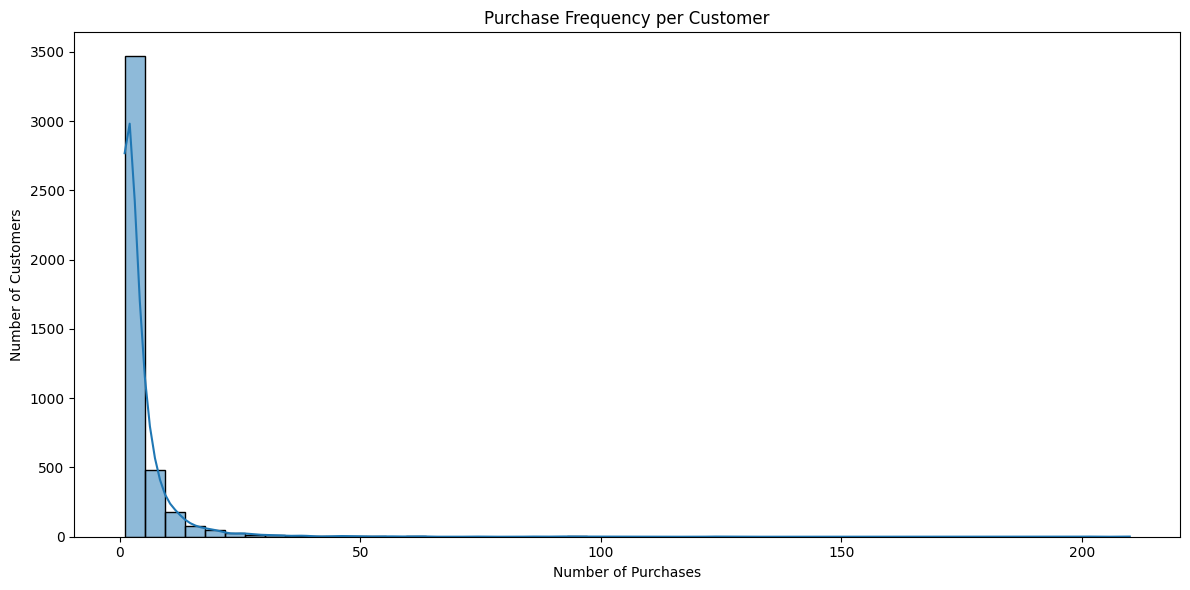

In [12]:
# Purchases per customer
customer_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Plot Purchase Frequency Distribution
plt.figure(figsize=(12,6))
sns.histplot(customer_frequency, bins=50, kde=True)
plt.title('Purchase Frequency per Customer')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


# 5. Customer Segmentation using RFM Analysis

RFM Analysis & Segmentation

>Created distinct customer groups (Champions, Loyal Customers, At Risk, etc.) for targeted marketing.

>Highlighted opportunities to reward top spenders and re-engage dormant customers.

**5.1. Calculating RFM Metrics**

In [16]:
import datetime as dt

# Set reference date as one day after the last InvoiceDate
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregate data to compute RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalRevenue': 'sum'
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalRevenue': 'Monetary'
}, inplace=True)

# Display RFM table
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


5.2. Scoring RFM Metrics

In [18]:
# For Recency
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=range(5, 0, -1))

# For Frequency
freq_quantiles, freq_bins = pd.qcut(rfm['Frequency'], q=5, retbins=True, duplicates='drop')
num_bins_freq = len(freq_bins) - 1
labels_freq = range(1, num_bins_freq + 1)
rfm['F_score'] = pd.cut(rfm['Frequency'], bins=freq_bins, labels=labels_freq, include_lowest=True)

# For Monetary
mon_quantiles, mon_bins = pd.qcut(rfm['Monetary'], q=5, retbins=True, duplicates='drop')
num_bins_mon = len(mon_bins) - 1
labels_mon = range(1, num_bins_mon + 1)
rfm['M_score'] = pd.cut(rfm['Monetary'], bins=mon_bins, labels=labels_mon, include_lowest=True)

# Convert scores to integer type
rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

# Combine RFM score
rfm['RFM_Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']

# Display updated RFM table
rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,7
12347.0,2,7,4310.00,5,4,5,14
12348.0,75,4,1797.24,2,3,4,9
12349.0,19,1,1757.55,4,1,4,9
12350.0,310,1,334.40,1,1,2,4


from matplotlib import pyplot as plt
_df_0['Recency'].plot(kind='hist', bins=20, title='Recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Monetary'].plot(kind='hist', bins=20, title='Monetary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['R_score'].plot(kind='hist', bins=20, title='R_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Monetary', y='R_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='R_score', y='F_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Recency'].plot(kind='line', figsize=(8, 4), title='Recency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Monetary'].plot(kind='line', figsize=(8, 4), title='Monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['R_score'].plot(kind='line', figsize=(8, 4), title='R_score')
plt.gca().spines[['top', 'right']].set_visible(False)

5.3. Segmenting Customers

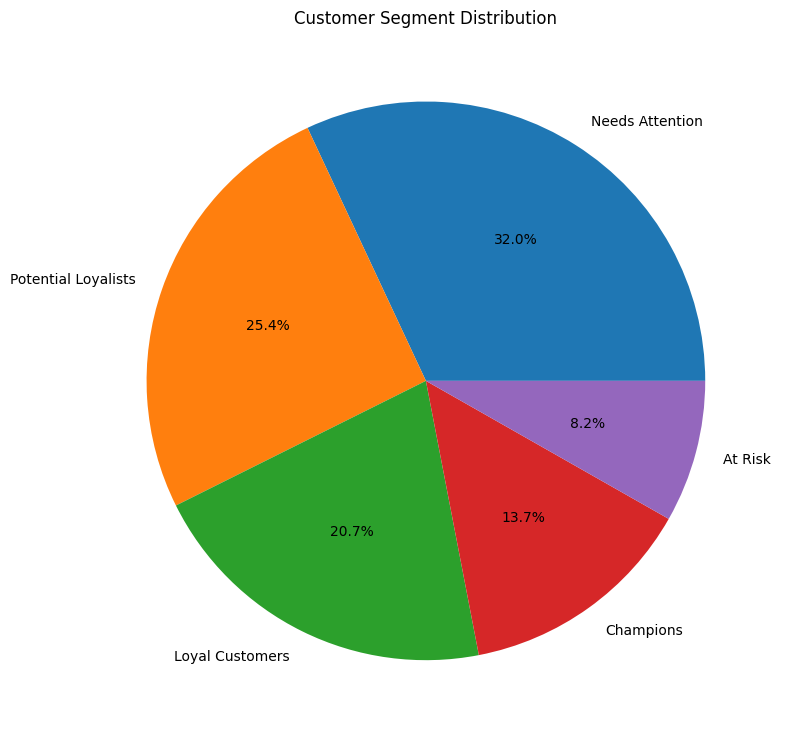

In [19]:
# Define segments based on RFM Score
def segment_me(df):
    if df['RFM_Score'] >= 13:
        return 'Champions'
    elif df['RFM_Score'] >= 10:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 7:
        return 'Potential Loyalists'
    elif df['RFM_Score'] >= 4:
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_me, axis=1)

# Count customers in each segment
segment_counts = rfm['Segment'].value_counts()

# Plot Customer Segment Distribution
plt.figure(figsize=(8,8))
segment_counts.plot.pie(autopct='%1.1f%%')
plt.title('Customer Segment Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()


# 6. Predictive Modeling - Churn Prediction

Churn Prediction

>Anticipated which customers might stop purchasing, allowing timely retention interventions.

>Guided improvements in personalization, timing, and outreach to reduce churn rates.

**6.1. Preparing Data**

In [20]:
# Define churn: Customers who haven't purchased in the last 6 months
rfm['Churn'] = np.where(rfm['Recency'] > 180, 1, 0)

# Features and target variable
features = rfm[['Recency', 'Frequency', 'Monetary']]
target = rfm['Churn']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


**6.2. Splitting Data**

In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.3, random_state=42)

# Verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3037, 3)
X_test shape: (1302, 3)
y_train shape: (3037,)
y_test shape: (1302,)


**6.3. Model Training**

In [22]:
# Initialize Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**6.4. Model Evaluation**

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1063
           1       1.00      1.00      1.00       239

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



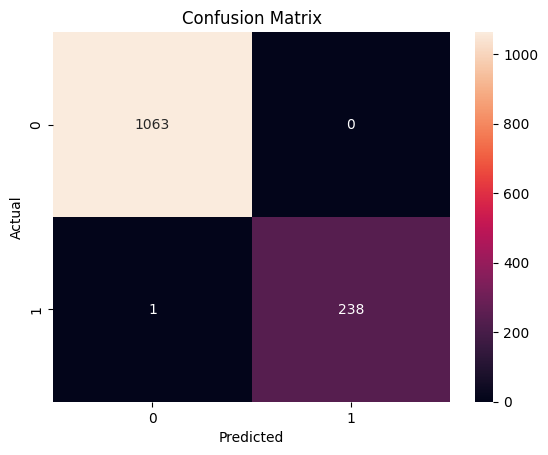

In [23]:
# Predict on test data
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 7. Time Series Analysis and Forecasting

Forecasting & Time Series Analysis

>Uncovered seasonal patterns for proactive demand planning and promotional alignment.

>Accurate sales forecasts informed budgeting, staffing, and inventory optimization.

**7.1. Prepare Time Series Data**

Number of observations: 13


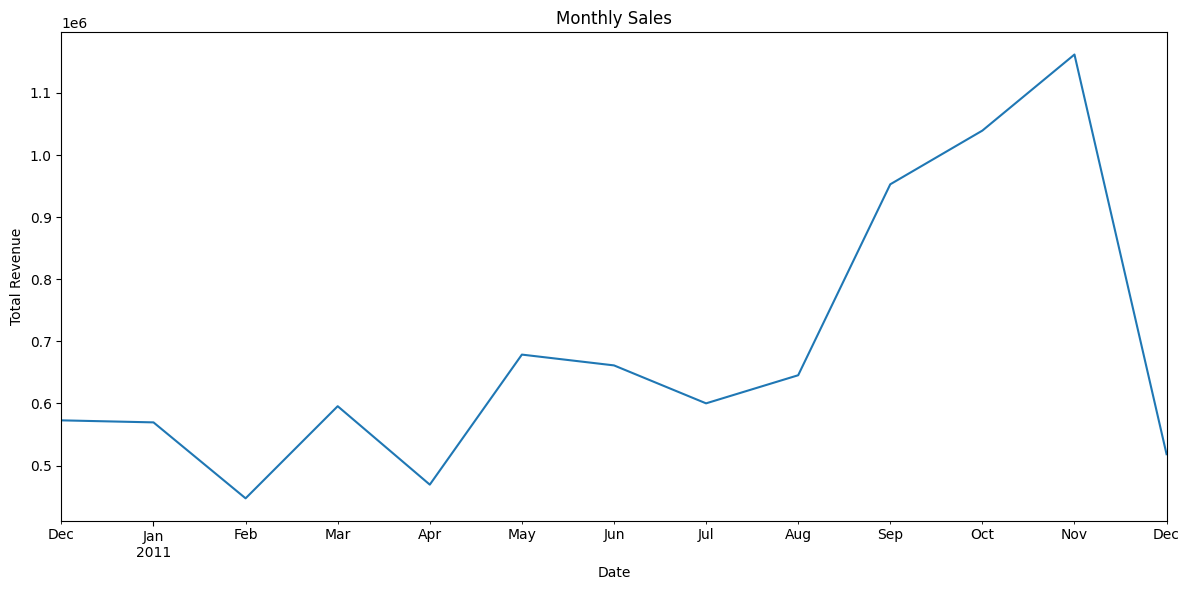

In [24]:
# Monthly sales data
monthly_sales = df.set_index('InvoiceDate').resample('M')['TotalRevenue'].sum()

# Check the number of observations
print("Number of observations:", len(monthly_sales))

# Plot the time series
plt.figure(figsize=(12,6))
monthly_sales.plot()
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


**7.2. Decompose Time Series using STL**

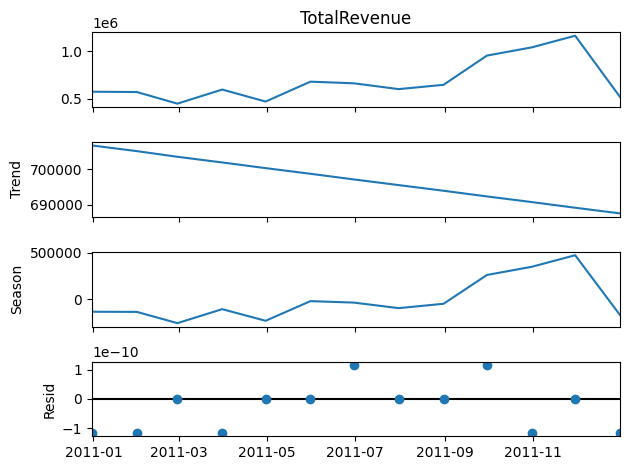

In [25]:
from statsmodels.tsa.seasonal import STL

# Apply STL decomposition
stl = STL(monthly_sales, period=12)
result = stl.fit()
result.plot()
plt.show()


**7.3. Forecasting with ARIMA**

<Figure size 1200x600 with 0 Axes>

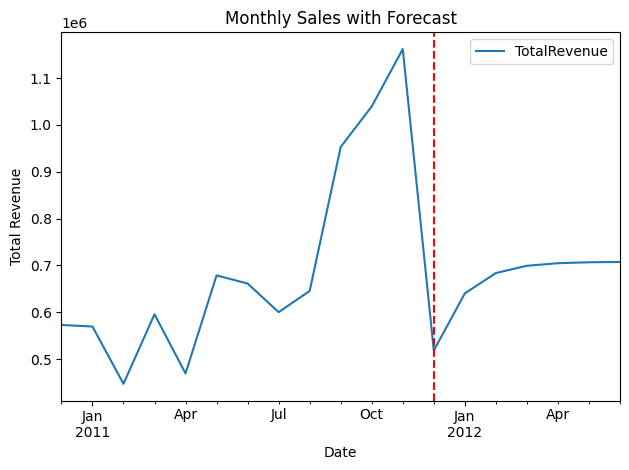

In [26]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(monthly_sales, order=(1,1,1))
model_fit = model.fit()

# Forecast next 6 months
forecast = model_fit.forecast(steps=6)

# Create forecast dates
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='M')

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({'TotalRevenue': forecast}, index=forecast_index)

# Combine actual and forecasted data
combined_sales = pd.concat([monthly_sales, forecast_df])

# Plot the forecast
plt.figure(figsize=(12,6))
combined_sales.plot()
plt.title('Monthly Sales with Forecast')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--')  # Mark the forecast start
plt.tight_layout()
plt.show()


# 8. Geographical Analysis

Geographical Analysis

>Identified high-revenue international markets, informing localized campaigns and potential global expansion.

>Supported decisions on regional product assortments, shipping strategies, and market entry tactics.

**8.1. Sales by Country**

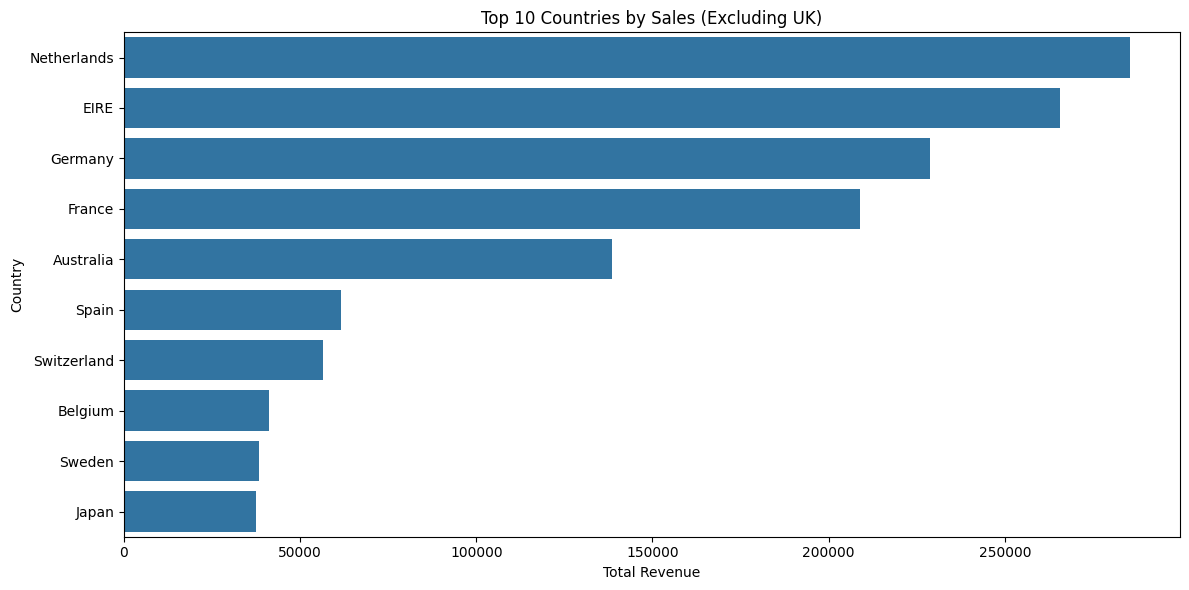

In [27]:
# Total sales per country
country_sales = df.groupby('Country')['TotalRevenue'].sum().sort_values(ascending=False)

# Exclude UK for better visualization
country_sales_no_uk = country_sales.drop('United Kingdom')

# Top 10 countries by sales excluding UK
top_countries = country_sales_no_uk.head(10)

# Plot Top Countries by Sales
plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Sales (Excluding UK)')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


**Overall Strategic Takeaways**

>Data-driven targeting optimizes marketing spend and boosts customer lifetime value.

>Predictive insights reduce churn, enhance loyalty, and improve operational efficiency.

>Global perspective and time-based insights strengthen the company’s competitive positioning.